In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import gzip
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np

from common import * 
import preprocess

In [5]:
DATA_DIR = 'data/clean_1'

log = preprocess.load_driving_log(os.path.join(DATA_DIR, DRIVING_LOG_CSV))
log = preprocess.smooth_control_inputs(log, 1)
print(log.head())

                                        center_image  \
0  data/clean_1/IMG/center_2016_12_04_21_13_56_21...   
1  data/clean_1/IMG/center_2016_12_04_21_13_56_33...   
2  data/clean_1/IMG/center_2016_12_04_21_13_56_45...   
3  data/clean_1/IMG/center_2016_12_04_21_13_56_57...   
4  data/clean_1/IMG/center_2016_12_04_21_13_56_72...   

                                          left_image  \
0  data/clean_1/IMG/left_2016_12_04_21_13_56_217.jpg   
1  data/clean_1/IMG/left_2016_12_04_21_13_56_334.jpg   
2  data/clean_1/IMG/left_2016_12_04_21_13_56_454.jpg   
3  data/clean_1/IMG/left_2016_12_04_21_13_56_577.jpg   
4  data/clean_1/IMG/left_2016_12_04_21_13_56_725.jpg   

                                         right_image  steering_angle  \
0  data/clean_1/IMG/right_2016_12_04_21_13_56_217...             0.0   
1  data/clean_1/IMG/right_2016_12_04_21_13_56_334...             0.0   
2  data/clean_1/IMG/right_2016_12_04_21_13_56_454...             0.0   
3  data/clean_1/IMG/right_2016_12_04_2

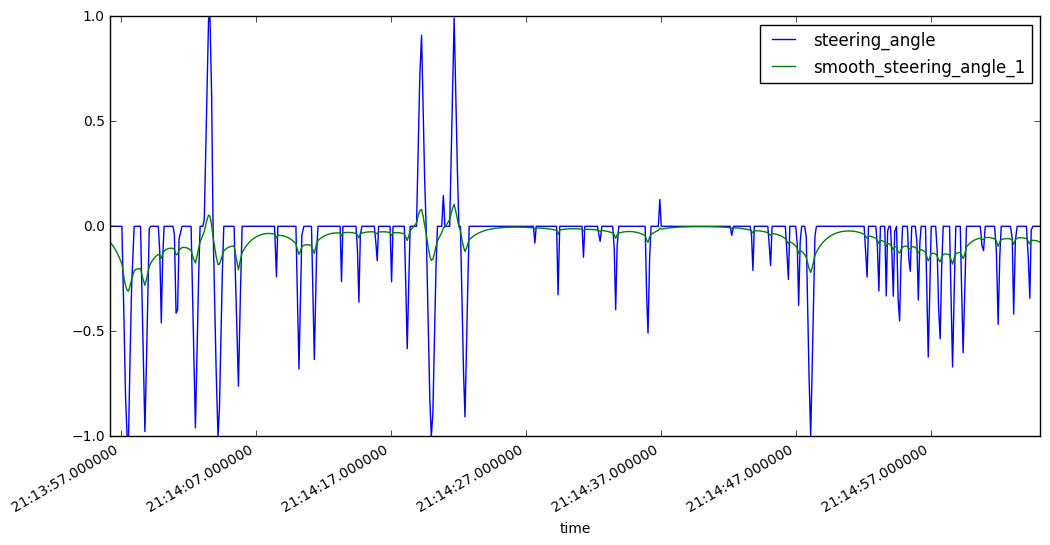

In [6]:
def plot_smooth_steering_angle():
    df = log[['time', 'steering_angle', 'smooth_steering_angle_1']]
    df = df[:600]
    df = df.set_index(['time'])
    df.plot(figsize=(12, 6))
plot_smooth_steering_angle()

In [ ]:
log.to_pickle(os.path.join(DATA_DIR, DRIVING_LOG_PICKLE))

# Bottleneck

Training is hopelessly slow if we don't botteneck the features.

In [ ]:
import bottleneck_features

In [ ]:
bottleneck_features.run(DATA_DIR)

In [ ]:
bottleneck_center_image = np.load(os.path.join(DATA_DIR, get_bottleneck_npy_filename('center_image')))
print(bottleneck_center_image[0].transpose().shape)
plt.imshow(bottleneck_center_image[0].transpose()[0:32,:,:])

# Model

In [7]:
import model


Using TensorFlow backend.


In [ ]:
model.run()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_2 (Flatten)              (None, 49152)         0           flatten_input_2[0][0]            
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 512)           25166336    flatten_2[0][0]                  
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 1)             513         dense_3[0][0]                    
Total params: 25166849
____________________________________________________________________________________________________
Train on 2418 samples, validate on 605 samples
Epoch 1/2
2418/2418 [==============================] - 52s - loss: 2486.4360 - val_loss: 0.0915
Epoch 2/2
2176/2418 [=====